<a href="https://colab.research.google.com/github/anyuanay/dsr_n2c2/blob/main/notebooks/NER_BiLSTM_CRF_annotated_corpus_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition Using Bidirectional LSTM and Conditional Random Fields (CRF): 
## Links:
1. https://blog.dominodatalab.com/named-entity-recognition-ner-challenges-and-model
2. https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/
3. The Groningen Meaning Bank (GMB): https://gmb.let.rug.nl/

## Download the Data
1. Download the data from: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/
2. Extract the data sets into your Google Drive under 'MyDrive/Colab Notebooks/n2c2/'

## Importing Libraries

In [1]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git 

In [2]:
# Use tensorflow 1.x to work with keras-contrib CRF
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
## Importing all required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [4]:
import tensorflow as tf

In [5]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Loading Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
## Loading data 
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/n2c2/ner_dataset.csv", encoding="iso-8859-1", header=0)

In [8]:
data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
data_df.shape

(1048575, 4)

### Extracting and filling up sentence id #

In [10]:
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
data_df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


## Exploring the Data

In [11]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


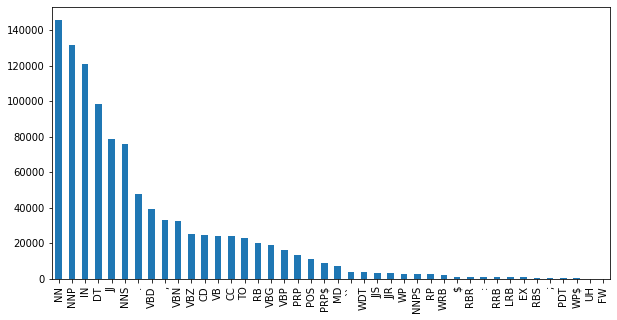

In [12]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

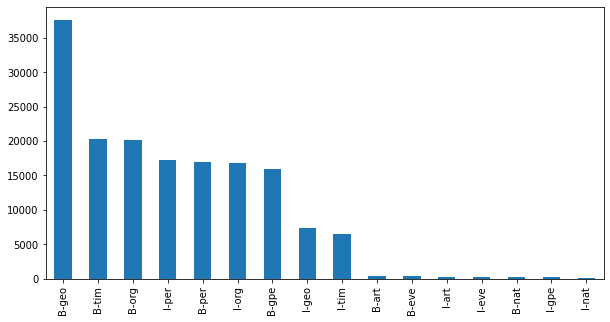

In [13]:
data_df[data_df["Tag"]!="O"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

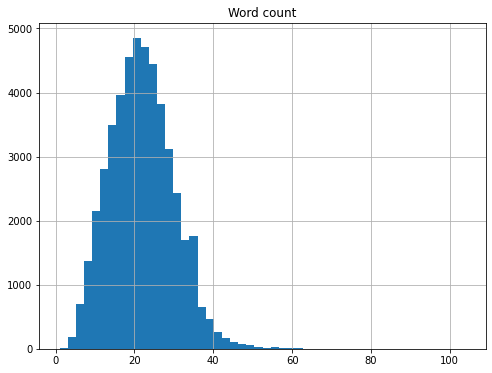

In [14]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [15]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


In [16]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 22480.


In [17]:
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


In [18]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35178
Number of unique tags : 17


## Constructing Word to Index and Tag to Index Mappings

In [19]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In [20]:
import operator
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
boys 2
275 3
TVN 4
Pharaohs 5
fade 6
jockey 7
hack 8
client 9


In [21]:
test_word = "Scotland"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word Scotland is 22548.
The word with index 22548 is Scotland.


In [22]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

## Constructing Sentences as Lists of (word, tag) Tuples

In [23]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

In [24]:
print(sentences[3])

[('Police', 'NNS', 'O'), ('put', 'VBD', 'O'), ('the', 'DT', 'O'), ('number', 'NN', 'O'), ('of', 'IN', 'O'), ('marchers', 'NNS', 'O'), ('at', 'IN', 'O'), ('10,000', 'CD', 'O'), ('while', 'IN', 'O'), ('organizers', 'NNS', 'O'), ('claimed', 'VBD', 'O'), ('it', 'PRP', 'O'), ('was', 'VBD', 'O'), ('1,00,000', 'CD', 'O'), ('.', '.', 'O')]


## Pre-processing
We extract the features (X) and labels (y) for the model. We discard the part of speech data, as it is not needed for this specific implementation.

In [25]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [26]:
# Replace each word with its index
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [28609, 3301, 20189, 22004, 29079, 21394, 33774, 24614, 35082, 21082, 16146, 33196, 24871, 25030, 16218, 21082, 2211, 3301, 9882, 17563, 3768, 27541, 21698, 7813]
y[0]: [4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 16, 4, 4, 4, 4, 4]


In [27]:
# Pad each sentence to the maximal sentence length in the corpus, 
# as the LSTM model expects a fixed length input. 
# This is where the extra "--PADDING--" key in the dictionary comes into play.

X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [28609, 3301, 20189, 22004, 29079, 21394, 33774, 24614, 35082, 21082, 16146, 33196, 24871, 25030, 16218, 21082, 2211, 3301, 9882, 17563, 3768, 27541, 21698, 7813, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 16, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
# Encode the tags as one-hot vectors:

TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]

print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [28609, 3301, 20189, 22004, 29079, 21394, 33774, 24614, 35082, 21082, 16146, 33196, 24871, 25030, 16218, 21082, 2211, 3301, 9882, 17563, 3768, 27541, 21698, 7813, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [29]:
# Split the resulting dataset into a training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset : 4796


In [30]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43163, 104), (4796, 104), (43163, 104, 18), (4796, 104, 18))

## Modeling
1. Reference: We will use the Keras library to create the Bi-LSTM-CRF model proposed in the paper: Bidirectional LSTM-CRF Models for Sequence Tagging: https://arxiv.org/abs/1508.01991

![bi_LSTM_CRF_NER](https://i.imgur.com/tSNQtfj.png)

In [31]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [32]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from keras import layers, optimizers
# Model definition
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 100)          10100     
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 18)           2178      
Total params: 1,811,678
Trainable params: 1,811,678
Non-trainable params: 0
______

In [33]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 40s - loss: 0.5085 - crf_accuracy: 0.8674 - val_loss: 0.1625 - val_crf_accuracy: 0.9667
Epoch 2/5
 - 38s - loss: 0.1364 - crf_accuracy: 0.9681 - val_loss: 0.0860 - val_crf_accuracy: 0.9727
Epoch 3/5
 - 38s - loss: 0.0692 - crf_accuracy: 0.9778 - val_loss: 0.0554 - val_crf_accuracy: 0.9841
Epoch 4/5
 - 39s - loss: 0.0425 - crf_accuracy: 0.9881 - val_loss: 0.0359 - val_crf_accuracy: 0.9899
Epoch 5/5
 - 38s - loss: 0.0283 - crf_accuracy: 0.9921 - val_loss: 0.0289 - val_crf_accuracy: 0.9915


In [35]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=e597a3c2a9fdda7586b92c143ead5511c6dfa30f004194ba39260dc15a60ed12
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=eb42ea0d12ea55f5848145063dd20133e7ad702d7ad5dad3b2069acdb2f5494b
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=1e054085938e1f074b982277fc381244fe1deaa4bb98fb4070881f3cf00b28a2
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f208a7c5850>,
       dtype=object))

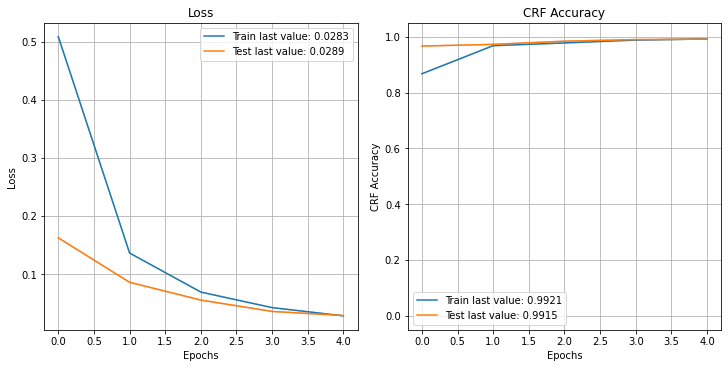

In [37]:
from plot_keras_history import plot_history
plot_history(history.history)

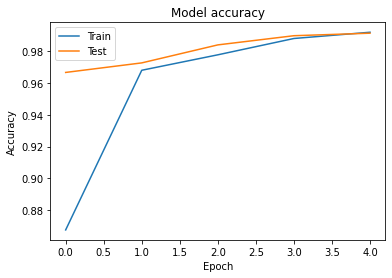

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_accuracy'])
plt.plot(history.history['val_crf_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

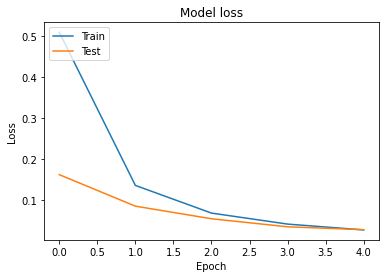

In [39]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluating the Model

In [40]:
y_pred = ner_model.predict(X_test)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

Accuracy: 0.9912/


In [45]:
y_pred[:2]

array([[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10,  7,  4,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [17, 17,  5,  4,  4,  4,  4,  4,  4, 11,  4,  4, 10,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [46]:
len(y_pred), len(y_test)

(4796, 4796)

In [48]:
y_test_flatten = [ele for sent in y_test for ele in sent]
y_pred_flatten = [ele for sent in y_pred for ele in sent]

In [42]:
from sklearn.metrics import classification_report

In [49]:
report = classification_report(y_true=y_test_flatten, y_pred=y_pred_flatten, labels=None)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    393603
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        24
           3       0.83      0.56      0.67       665
           4       0.98      1.00      0.99     89035
           5       0.84      0.78      0.81      1668
           6       0.00      0.00      0.00        47
           7       0.80      0.66      0.72       757
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        30
          10       0.79      0.88      0.83      3777
          11       0.88      0.83      0.86      2033
          12       0.00      0.00      0.00        19
          13       0.82      0.64      0.72      1802
          14       0.74      0.62      0.67      2033
          15       0.00      0.00      0.00         7
          16       0.96      0.90      0.93      1597
          17       0.82    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It appears that the model is doing quite well, however this is slightly misleading. This is a highly imbalanced dataset because of the very high number of O-tags that are present in the training and test data. There is further imbalance between the samples including the various tag classes. A better inspection would be to construct confusion matrices for each tag and judge the model performance based on those. We can construct a simple Python function to assist with inspection of the confusion matrices for individual tags. We use two randomly selected tags to give us a sense of what the confusion matrices for individual tags would look like

In [51]:
# Check individual tags

from sklearn.metrics import multilabel_confusion_matrix

def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: B-nat
[[498756      0]
 [    28      0]]
Tag accuracy: 1.000 

Tag name: B-org
[[496304    447]
 [   770   1263]]
Tag accuracy: 0.998 



## Labeling Individual Sentence
Finally, we run a manual test by constructing a sample sentence and getting predictions for the detected entities. We tokenize, pad, and convert all words to indices. Then we call the model and print the predicted tags. The sentence we use for our test is "President Obama became the first sitting American president to visit Hiroshima".

In [67]:
sentence = "President Obama became the first sitting American president to visit Hiroshima"

In [68]:
import re, string
re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")

sentence = re_tok.sub(r" ", sentence).split()

sentence

['President',
 'Obama',
 'became',
 'the',
 'first',
 'sitting',
 'American',
 'president',
 'to',
 'visit',
 'Hiroshima']

In [69]:
padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

In [73]:
pred

array([[17,  5,  4,  4,  4,  4, 16,  4,  4,  4, 10,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  0]])

In [75]:
retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

President      : B-per
Obama          : I-per
became         : O    
the            : O    
first          : O    
sitting        : O    
American       : B-gpe
president      : O    
to             : O    
visit          : O    
Hiroshima      : B-geo

